In [1]:
import sys
sys.path.append('../../scripts/')

import mido
import numpy as np
import matplotlib.pyplot as plt
import librosa
import math
import librosa.display
import IPython.display
from skimage.transform import resize
from scipy.stats.stats import pearsonr
import glob
import csv
%matplotlib inline

from aug_density_map import *
from mappings import *

from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import pandas as pd

ModuleNotFoundError: No module named 'aug_density_map'

In [ ]:
file_names = []
for file in glob.glob("../../data/misc/*.wav"):
    file_names.append(file[:-4])
    
list_2015 = glob.glob("../../data/2015/*.wav")[:4]
    
for file in list_2015:
    file_names.append(file[:-4])

In [3]:
def filter_negatives(x):
    if x < 0:
        return 0
    else:
        return x

f_neg = np.vectorize(filter_negatives)

def db_norm(spec_db):
    return f_neg(spec_db + 120)

In [4]:
for f in range(2,3):
    for n_fft in [2048]:

        file_name = file_names[f]
        print(f)
        print(file_name)
        midi = mido.MidiFile(file_name + '.midi')
        y, sr = librosa.load(file_name + '.wav', sr=44100)

        timestamp = int((len(y) / sr) // 2) # pega o meio da gravação (só analisaremos 30 segundos do meio da música)
        y = y[sr*timestamp:sr*(timestamp+30)]

        hop_size = n_fft//4
        spec = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
        spec_amp = np.abs(spec)
        spec_db = db_norm(librosa.amplitude_to_db(spec_amp, ref=np.max))
        
        proll = midi_to_piano_roll(midi, timestamp)

        for i in [8]:
            try:
                kernel = [i*100,i*100]

                proll_den = calc_map_aug2(sound_event_to_tfp(proll, spec.shape[1], n_fft=n_fft), kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
                proll_h_den = calc_map_aug2(sound_event_to_tfp(compose_sound_event_map(proll), spec.shape[1], n_fft=n_fft), kernel, type='avg', n_fft=n_fft, hop_size=hop_size)

                shannon_db = calc_map_aug2(spec_db, kernel, type='shannon', n_fft=n_fft, hop_size=hop_size)
                stddev_amp = calc_map_aug2(spec_amp, kernel, type='std dev', n_fft=n_fft, hop_size=hop_size)
                var_amp = calc_map_aug2(spec_amp, kernel, type='var', n_fft=n_fft, hop_size=hop_size)
                maxmin_amp = calc_map_aug2(spec_amp, kernel, type='maxmin', n_fft=n_fft, hop_size=hop_size)
                amp   = calc_map_aug2(spec_amp, kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
                en_db = calc_map_aug2(spec_db, kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
                
                PIANOROLL_GTRUTH = (proll_den > 0).astype(int)
                PROLL_HARM_GTRUTH = (proll_h_den > 0).astype(int)
                    
#                 size_results = len(proll_den.flatten())
#                 file_name_list = [file_name] * size_results

#                 partial_results_df = pd.DataFrame(columns=['file name', 'label', 'shannon db', 'std dev amp', 'maxmin amp', 'amp', 'en db'])
#                 partial_results_df['file name'] = file_name_list
#                 partial_results_df['label'] = label
#                 partial_results_df['shannon db'] = shannon_db.flatten()
#                 partial_results_df['std dev amp'] = var_amp.flatten()
#                 partial_results_df['maxmin amp'] = maxmin_amp.flatten()
#                 partial_results_df['amp'] = amp.flatten()
#                 partial_results_df['en db'] = en_db.flatten()        
                
#                 partial_results_df.to_csv('../../results/classification_experiment/features.csv', mode='a', header=False)
                print('Writing complete.')
                
            except:
                print('nao deu...')

2
../../data/misc/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2
Writing complete.


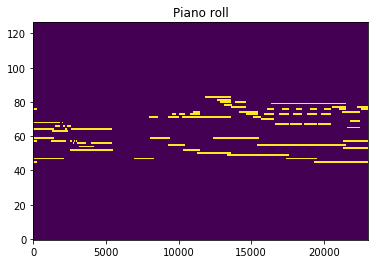

In [5]:
plt.figure()
plt.imshow(proll, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Piano roll')

In [6]:
IPython.display.Audio(y, rate=sr)

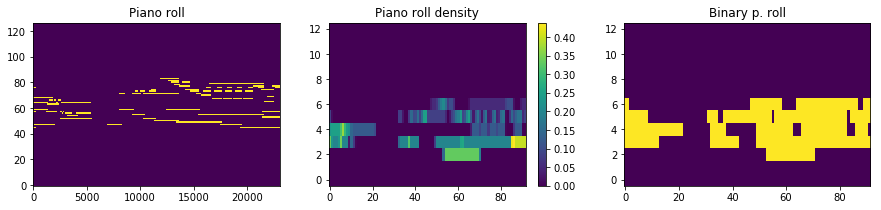

In [7]:
plt.figure(figsize=[15,3])

plt.subplot(1,3,1)
plt.imshow(proll, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Piano roll')

plt.subplot(1,3,2)
plt.imshow(proll_den, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Piano roll density')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(PIANOROLL_GTRUTH, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Binary p. roll')

In [8]:
PROLL_HARM_GTRUTH_004 = (proll_h_den > 0.03).astype(int)
PROLL_HARM_GTRUTH_1 = (proll_h_den > 0.1).astype(int)

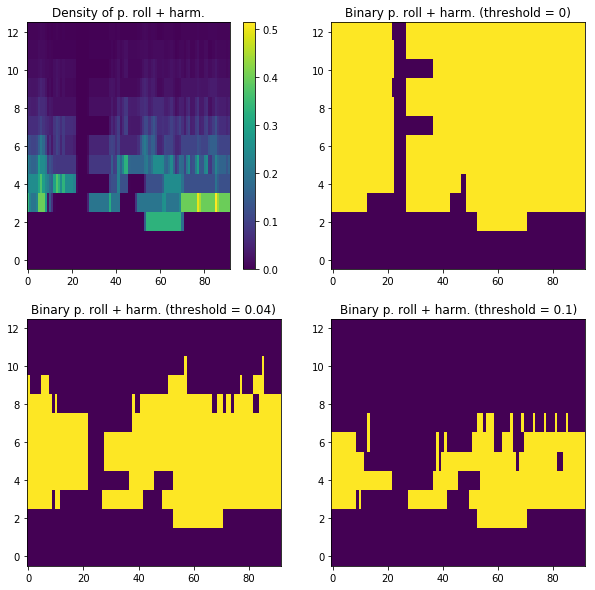

In [15]:
plt.figure(figsize=[10,10])

plt.subplot(2,2,1)
plt.imshow(proll_h_den, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Density of p. roll + harm.')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(PROLL_HARM_GTRUTH, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Binary p. roll + harm. (threshold = 0)')

plt.subplot(2,2,3)
plt.imshow(PROLL_HARM_GTRUTH_004, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Binary p. roll + harm. (threshold = 0.04)')

plt.subplot(2,2,4)
plt.imshow(PROLL_HARM_GTRUTH_1, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Binary p. roll + harm. (threshold = 0.1)')

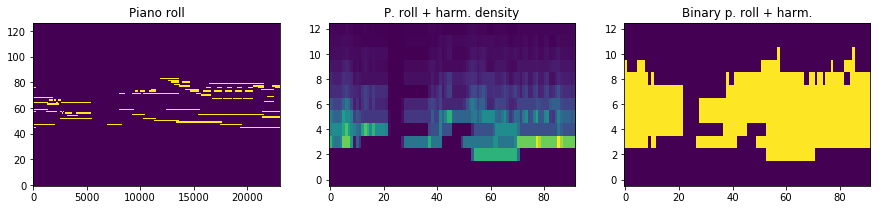

In [10]:
plt.figure(figsize=[15,3])

plt.subplot(1,3,1)
plt.imshow(proll, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Piano roll')

plt.subplot(1,3,2)
plt.imshow(proll_h_den, aspect='auto')
plt.gca().invert_yaxis()
plt.title('P. roll + harm. density')

plt.subplot(1,3,3)
plt.imshow(PROLL_HARM_GTRUTH, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Binary p. roll + harm.')

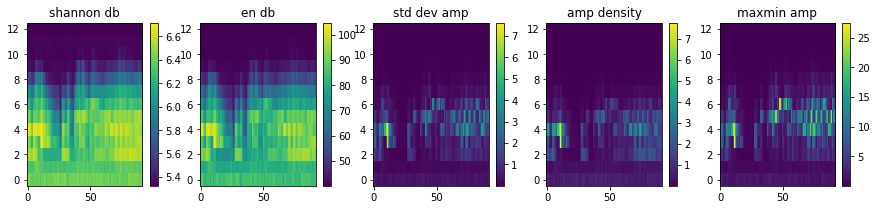

In [11]:
plt.figure(figsize=[15,3])

plt.subplot(1,5,1)
plt.imshow(shannon_db, aspect='auto')
plt.gca().invert_yaxis()
plt.title('shannon db')
plt.colorbar()

plt.subplot(1,5,4)
plt.imshow(amp, aspect='auto')
plt.gca().invert_yaxis()
plt.title('amp density')
plt.colorbar()

plt.subplot(1,5,3)
plt.imshow(stddev_amp, aspect='auto')
plt.gca().invert_yaxis()
plt.title('std dev amp')
plt.colorbar()

plt.subplot(1,5,2)
plt.imshow(en_db, aspect='auto')
plt.gca().invert_yaxis()
plt.title('en db')
plt.colorbar()

plt.subplot(1,5,5)
plt.imshow(maxmin_amp, aspect='auto')
plt.gca().invert_yaxis()
plt.title('maxmin amp')
plt.colorbar()

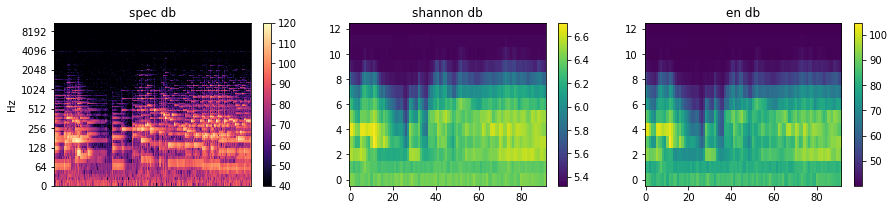

In [12]:
plt.figure(figsize=[15,3])

plt.subplot(1,3,1)
librosa.display.specshow(spec_db, y_axis='log')
plt.title('spec db')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(shannon_db, aspect='auto')
plt.gca().invert_yaxis()
plt.title('shannon db')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(en_db, aspect='auto')
plt.gca().invert_yaxis()
plt.title('en db')
plt.colorbar()

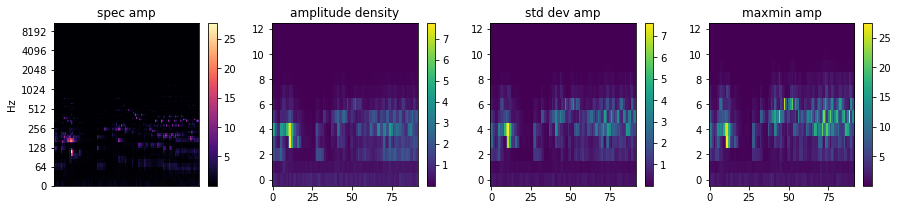

In [13]:
plt.figure(figsize=[15,3])

plt.subplot(1,4,1)
librosa.display.specshow(spec_amp, y_axis='log')
plt.title('spec amp')
plt.colorbar()

plt.subplot(1,4,2)
plt.imshow(amp, aspect='auto')
plt.gca().invert_yaxis()
plt.title('amplitude density')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(stddev_amp, aspect='auto')
plt.gca().invert_yaxis()
plt.title('std dev amp')
plt.colorbar()

plt.subplot(1,4,4)
plt.imshow(maxmin_amp, aspect='auto')
plt.gca().invert_yaxis()
plt.title('maxmin amp')
plt.colorbar()

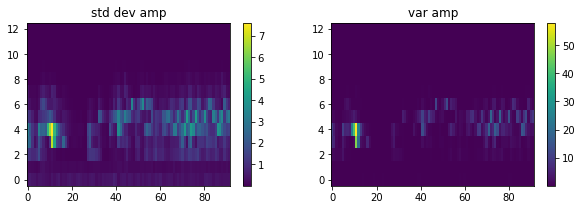

In [14]:
plt.figure(figsize=[10,3])

plt.subplot(1,2,1)
plt.imshow(stddev_amp, aspect='auto')
plt.gca().invert_yaxis()
plt.title('std dev amp')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(var_amp, aspect='auto')
plt.gca().invert_yaxis()
plt.title('var amp')
plt.colorbar()

Analisar em detalhe os modelos treinados: começar por shannon

In [25]:
features = pd.read_csv('../../results/classification_experiment/two_labels/features_800.csv')

Treina o modelo:

In [30]:
def train_model(features, type_gtruth):
    if type_gtruth == 'piano roll':
        Y = features['label proll'].values
    else:
        Y = features['label proll harm'].values

    feature = 'shannon db'
    X = features[feature].values.reshape(-1, 1)

    idx = int(len(Y) * 0.2)

    test_Y = Y[:idx]
    test_X = X[:idx]
    training_Y = Y[idx:]
    training_X = X[idx:]

    model = GaussianNB()
    model.fit(training_X, training_Y)
    return model

In [31]:
model_proll = train_model(features, 'piano roll')
model_harm = train_model(features, 'piano roll harm')

Prevê arquivo específico:

In [44]:
for f in range(3,4):
    for n_fft in [2048]:

        file_name = file_names[f]
        print(f)
        print(file_name)
        midi = mido.MidiFile(file_name + '.midi')
        y, sr = librosa.load(file_name + '.wav', sr=44100)

        timestamp = int((len(y) / sr) // 2) # pega o meio da gravação (só analisaremos 30 segundos do meio da música)
        y = y[sr*timestamp:sr*(timestamp+30)]

        hop_size = n_fft//4
        spec = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
        spec_amp = np.abs(spec)
        spec_db = db_norm(librosa.amplitude_to_db(spec_amp, ref=np.max))
        
        proll = midi_to_piano_roll(midi, timestamp)

        kernel = [800,800]

        proll_den = calc_map_aug2(sound_event_to_tfp(proll, spec.shape[1], n_fft=n_fft), kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
        proll_h_den = calc_map_aug2(sound_event_to_tfp(compose_sound_event_map(proll), spec.shape[1], n_fft=n_fft), kernel, type='avg', n_fft=n_fft, hop_size=hop_size)

        shannon_db = calc_map_aug2(spec_db, kernel, type='shannon', n_fft=n_fft, hop_size=hop_size)
#       stddev_amp = calc_map_aug2(spec_amp, kernel, type='std dev', n_fft=n_fft, hop_size=hop_size)
#       var_amp = calc_map_aug2(spec_amp, kernel, type='var', n_fft=n_fft, hop_size=hop_size)
#       maxmin_amp = calc_map_aug2(spec_amp, kernel, type='maxmin', n_fft=n_fft, hop_size=hop_size)
#       amp   = calc_map_aug2(spec_amp, kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
#       en_db = calc_map_aug2(spec_db, kernel, type='avg', n_fft=n_fft, hop_size=hop_size)
                
        PIANOROLL_GTRUTH = (proll_den > 0).astype(int)
        PROLL_HARM_GTRUTH = (proll_h_den > 0.1).astype(int)
            
        predicted_Y_proll = np.reshape(model_proll.predict(shannon_db.flatten().reshape(-1, 1)), PROLL_HARM_GTRUTH.shape)
        predicted_Y_harm = np.reshape(model_harm.predict(shannon_db.flatten().reshape(-1, 1)), PROLL_HARM_GTRUTH.shape)
        predicted_probs = model.predict_proba(shannon_db.flatten().reshape(-1, 1))

3
../../data/misc/MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--1


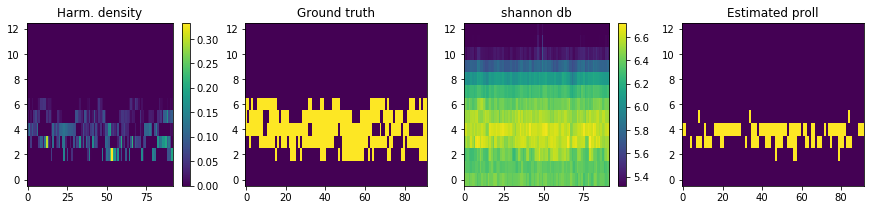

In [45]:
plt.figure(figsize=[15,3])

plt.subplot(1,4,1)
plt.imshow(proll_den, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Harm. density')
plt.colorbar()

plt.subplot(1,4,2)
plt.imshow(PIANOROLL_GTRUTH, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Ground truth')

plt.subplot(1,4,3)
plt.imshow(shannon_db, aspect='auto')
plt.title('shannon db')
plt.colorbar()
plt.gca().invert_yaxis()

plt.subplot(1,4,4)
plt.imshow(predicted_Y_proll, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Estimated proll')

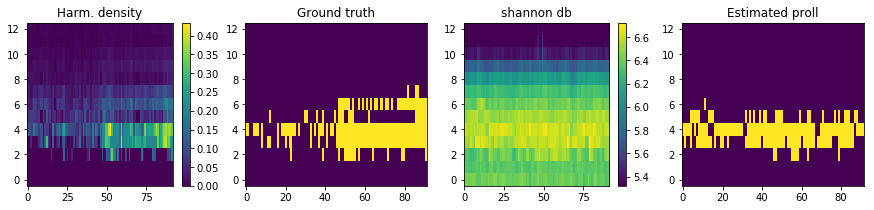

In [46]:
plt.figure(figsize=[15,3])

plt.subplot(1,4,1)
plt.imshow(proll_h_den, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Harm. density')
plt.colorbar()

plt.subplot(1,4,2)
plt.imshow(PROLL_HARM_GTRUTH, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Ground truth')

plt.subplot(1,4,3)
plt.imshow(shannon_db, aspect='auto')
plt.title('shannon db')
plt.colorbar()
plt.gca().invert_yaxis()

plt.subplot(1,4,4)
plt.imshow(predicted_Y_harm, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Estimated proll')

In [47]:
def false_neg_pos(ground_truth, estimation):
    false_positive = f_neg(estimation - ground_truth)
    false_negative = f_neg(ground_truth - estimation)
    return false_positive, false_negative

In [48]:
false_positive, false_negative = false_neg_pos(PROLL_HARM_GTRUTH, predicted_Y_harm)

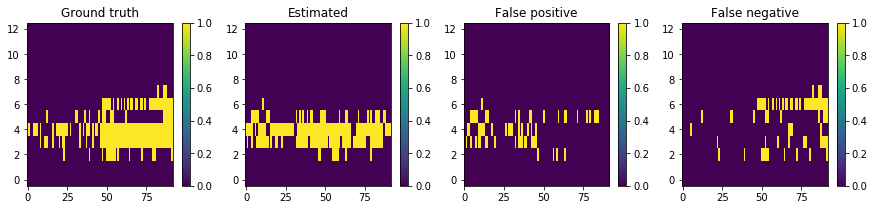

In [49]:
plt.figure(figsize=[15,3])

plt.subplot(1,4,1)
plt.imshow(PROLL_HARM_GTRUTH, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Ground truth')
plt.colorbar()

plt.subplot(1,4,2)
plt.imshow(predicted_Y_harm, aspect='auto')
plt.gca().invert_yaxis()
plt.title('Estimated')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(false_positive, aspect='auto')
plt.gca().invert_yaxis()
plt.title('False positive')
plt.colorbar()

plt.subplot(1,4,4)
plt.imshow(false_negative, aspect='auto')
plt.gca().invert_yaxis()
plt.title('False negative')
plt.colorbar()
